# Looking for a pipeline for segmenting seeds in images

## Status

- 2023-07-23: The segmentation is working fairly well except for one thing,
    - I cannot join the seed head to the seed body yet.

In [1]:
import math
from collections import namedtuple
from pathlib import Path

import ipywidgets as widgets
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage
from ipywidgets import fixed, interact
from scipy import fft
from scipy import ndimage as ndi
from scipy import signal
from scipy.cluster.vq import kmeans2
from scipy.signal import convolve2d as conv2
from skimage import (
    color,
    data,
    draw,
    exposure,
    feature,
    filters,
    graph,
    img_as_float,
    io,
    measure,
    morphology,
    restoration,
    segmentation,
    transform,
    util,
)
from skimage.filters import rank, thresholding

In [2]:
IMAGE_DIR = Path(".") / "data" / "images"

matplotlib.rcParams.update({"font.size": 11})

In [3]:
suffixes = (".jpeg", ".png")

PATHS = [p for p in IMAGE_DIR.glob("*.*") if p.suffix in suffixes]
path = PATHS[0]

## Get initial grayscale image

(dtype('uint8'), 18, 254)

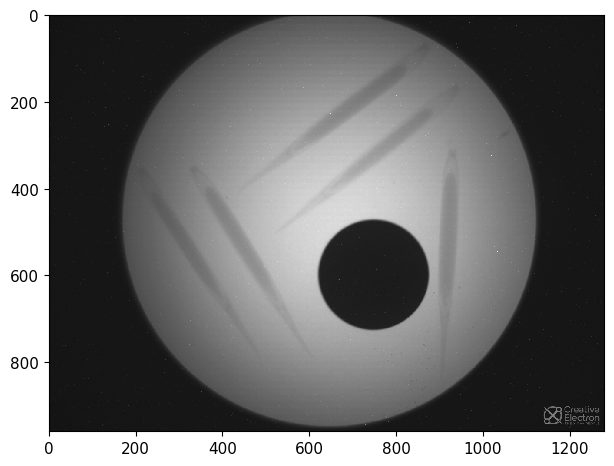

In [4]:
orig = io.imread(path)
gray = np.uint8(color.rgb2gray(orig) * 255.0)
io.imshow(gray)
gray.dtype, gray.min(), gray.max()

## Display a before & after manipulation pair of images

In [5]:
def two_up(input_image, output_image, output_title):
    fig, axes = plt.subplots(
        nrows=1, ncols=2, sharex=True, sharey=True, figsize=(16, 8)
    )
    ax = axes.ravel()

    ax[0].imshow(input_image, cmap=plt.cm.gray)
    ax[0].set_title("input image")
    ax[0].axis("off")

    ax[1].imshow(output_image, cmap=plt.cm.gray)
    ax[1].set_title(output_title)
    ax[1].axis("off")

    plt.show()

## Functions for manipulating images

#### Image mask functions

In [6]:
def get_mask(gray):
    threshold = filters.threshold_otsu(gray)
    mask = gray > threshold

    mask = morphology.remove_small_objects(mask, 64)
    mask = morphology.remove_small_holes(mask, 64)

    rr, cc = draw.rectangle((750, 1100), mask.shape, shape=mask.shape)
    mask[rr, cc] = 0

    two_up(gray, mask, "mask")
    return mask

In [7]:
def mask_image(image, mask):
    new = image.copy() * mask
    two_up(image, new, "mask_image")
    return new

#### Measure functions

In [8]:
def label(image, connectivity=None):
    labels = measure.label(image, connectivity=connectivity)
    overlay = color.label2rgb(labels, image, alpha=0.7, bg_label=0, bg_color=None)
    two_up(image, overlay, "label")
    return labels

In [9]:
def regionprops(labels):
    props = measure.regionprops(labels)
    return props

In [10]:
def regionprops_table(labels):
    props = measure.regionprops_table(labels)
    return props

#### Morphology functions

In [11]:
def binary_dilation(image, footprint=None):
    new = morphology.binary_dilation(image, footprint=footprint)
    two_up(image, new, "binary_dilation")
    return new

In [12]:
def binary_erosion(image, footprint=None):
    new = morphology.binary_erosion(image, footprint=footprint)
    two_up(image, new, "binary_erosion")
    return new

In [13]:
def remove_small_holes(image, area_threshold=0):
    new = morphology.remove_small_holes(image, area_threshold=area_threshold)
    two_up(image, new, "remove_small_holes")
    return new

In [14]:
def remove_small_objects(image, min_size=0):
    new = morphology.remove_small_objects(image, min_size=min_size)
    two_up(image, new, "remove_small_objects")
    return new

#### Exposure functions

In [15]:
def adjust_gamma(image, gamma=1.0, gain=1.0):
    new = exposure.adjust_gamma(image, gamma=gamma, gain=gain)
    two_up(image, new, "adjust_gamma")
    return new

In [16]:
def adjust_log(image, gain=1.0, inv=False):
    new = exposure.adjust_log(image, gain=gain, inv=inv)
    two_up(image, new, "adjust_log")
    return new

In [17]:
def adjust_sigmoid(image, cutoff=0.5, gain=10, inv=False):
    new = exposure.adjust_sigmoid(image, cutoff=cutoff, gain=gain, inv=inv)
    two_up(image, new, "adjust_sigmoid")
    return new

In [18]:
def equalize_adapthist(image, nbins=255, kernel_size=None, clip_limit=0.01):
    new = exposure.equalize_adapthist(
        image, nbins=nbins, kernel_size=kernel_size, clip_limit=clip_limit
    )
    two_up(image, new, "equalize_adapthist")
    return new

#### Feature functions

In [19]:
def canny(image, sigma=1, mask=None, low_threshold=None, high_threshold=None):
    new = feature.canny(
        image,
        sigma=sigma,
        mask=mask,
        low_threshold=low_threshold,
        high_threshold=high_threshold,
    )
    two_up(image, new, "canny")
    return new

#### Filter functions

In [20]:
def farid(image, mask=None):
    new = filters.farid(image, mask=mask)
    two_up(image, new, "farid")
    return new

In [21]:
def gaussian(image, sigma=1):
    new = filters.gaussian(image, sigma=sigma)
    two_up(image, new, "gaussian")
    return new

In [22]:
def meijering(image, black_ridges, sigmas):
    new = filters.meijering(image, black_ridges=black_ridges, sigmas=sigmas)
    two_up(image, new, "meijering")
    return new

In [23]:
def prewitt(image, mask=None):
    new = filters.prewitt(image, mask=mask)
    two_up(image, new, "prewitt")
    return new

In [24]:
def roberts(image, mask=None):
    new = filters.roberts(image, mask=mask)
    two_up(image, new, "roberts")
    return new

In [25]:
def sato(image, black_ridges, sigmas):
    new = filters.sato(image, black_ridges=black_ridges, sigmas=sigmas)
    two_up(image, new, "sato")
    return new

In [26]:
def sobel(image, mask=None):
    new = filters.sobel(image, mask=mask)
    two_up(image, new, "sobel")
    return new

In [27]:
def threshold_niblack(image, window_size=15, k=0.2):
    new = filters.threshold_niblack(image, window_size=window_size, k=k)
    two_up(image, new, "threshold_niblack")
    return new

In [28]:
def threshold_otsu(image):
    thresh = filters.threshold_otsu(image)
    binary = image > thresh
    binary = binary & mask
    two_up(image, binary, "threshold_otsu")
    return binary

In [29]:
def threshold_sauvola(image, window_size=15, k=0.2):
    thresh = filters.threshold_sauvola(image, window_size=window_size, k=k)
    binary = image > thresh
    binary = binary & mask
    two_up(image, binary, "threshold_sauvola")
    return binary

In [30]:
def threshold_yen(image):
    thresh = filters.threshold_yen(image)
    binary = image > thresh
    binary = binary & mask
    two_up(image, binary, "threshold_yen")
    return binary

In [31]:
def unsharp_mask(image, radius=1, amount=1):
    new = filters.unsharp_mask(image, radius=radius, amount=amount)
    two_up(image, new, "unsharp_mask")
    return new

#### Rank filter functions

In [32]:
def autolevel_percentile(image, disk=50, low=0.2, high=0.8, mask=None):
    new = rank.autolevel_percentile(
        image, footprint=morphology.disk(disk), p0=low, p1=high, mask=mask
    )
    two_up(image, new, "autolevel_percentile")
    return new

In [33]:
def enhance_contrast_disk(image, radius=5, mask=None):
    new = rank.enhance_contrast(image, footprint=morphology.disk(radius), mask=mask)
    two_up(image, new, "enhance_contrast_disk")
    return new

In [34]:
def equalize_disk(image, radius=5, mask=None):
    new = rank.equalize(image, footprint=morphology.disk(radius), mask=mask)
    two_up(image, new, "equalize_disk")
    return new

In [35]:
def maximum_disk(image, radius=5, mask=None):
    new = rank.maximum(image, morphology.disk(radius), mask=mask)
    two_up(image, new, "maximum_disk")
    return new

In [36]:
def majority_disk(image, radius=5, mask=None):
    new = rank.majority(image, morphology.disk(radius), mask=mask)
    two_up(image, new, "majority_disk")
    return new

In [37]:
def mean_disk(image, radius=5, mask=None):
    new = rank.mean(image, morphology.disk(radius), mask=mask)
    two_up(image, new, "mean_disk")
    return new

In [38]:
def mean_bilateral_disk(image, radius=5, mask=None):
    new = rank.mean_bilateral(image, morphology.disk(radius), mask=mask)
    two_up(image, new, "mean_bilateral_disk")
    return new

In [39]:
def minimum_disk(image, radius=5, mask=None):
    new = rank.minimum(image, morphology.disk(radius), mask=mask)
    two_up(image, new, "minimum_disk")
    return new

In [40]:
def modal_disk(image, radius=5, mask=None):
    new = rank.modal(image, morphology.disk(radius), mask=mask)
    two_up(image, new, "modal_disk")
    return new

In [41]:
def noise_filter_disk(image, radius=5, mask=None):
    new = rank.noise_filter(image, morphology.disk(radius), mask=mask)
    two_up(image, new, "noise_filter_disk")
    return new

In [42]:
def otsu_disk(image, radius=5, mask=None):
    new = rank.otsu(image, morphology.disk(radius), mask=mask)
    two_up(image, new, "otsu_disk")
    return new

In [43]:
def subtract_mean_percbinary_erosionentile_disk(
    image, radius=5, mask=None, p0=0.0, p1=1.0
):
    new = rank.subtract_mean_percentile(image, morphology.disk(radius), mask=mask)
    two_up(image, new, "subtract_mean_percentile_disk")
    return new

In [44]:
def threshold_disk(image, radius=5, mask=None):
    new = rank.threshold(image, morphology.disk(radius), mask=mask)
    two_up(image, new, "threshold_disk")
    return new

#### Restoration functions

In [45]:
def denoise_bilateral(image, sigma_spatial=1.0):  # , win_size=None):
    new = restoration.denoise_bilateral(
        image, sigma_spatial=sigma_spatial
    )  # , win_size=win_size)
    two_up(image, new, "denoise_bilateral")
    return new

In [46]:
def denoise_nl_means(image, patch_size=7, patch_distance=11, h=0.1):
    new = restoration.denoise_nl_means(
        image, patch_size=patch_size, patch_distance=patch_distance, h=h
    )
    two_up(image, new, "denoise_nl_means")
    return new

In [47]:
def denoise_tv_bregman(image, weight=5.0):
    new = restoration.denoise_tv_bregman(image, weight=weight)
    two_up(image, new, "denoise_tv_bregman")
    return new

In [48]:
def denoise_tv_chambolle(image, weight=0.1):
    new = restoration.denoise_tv_chambolle(image, weight=weight)
    two_up(image, new, "denoise_tv_chambolle")
    return new

#### Utility functions

In [49]:
def invert(image):
    new = util.invert(image)
    two_up(image, new, "invert")
    return new

#### Segmentation functions

In [50]:
def flood_fill(image, seed_point, new_value=128):
    new = segmentation.flood_fill(image, seed_point, new_value)
    two_up(image, new, "flood_fill")
    return new

#### Circle functions

In [51]:
Circle = namedtuple("Circle", "x y radius")

In [52]:
def find_circles(edges, small=75, large=500, count=2):
    # Detect radii
    hough_radii = np.arange(small, large, 4)
    hough_res = transform.hough_circle(edges, hough_radii)

    # Select the most prominent circles
    accums, cx, cy, radii = transform.hough_circle_peaks(
        hough_res, hough_radii, total_num_peaks=count
    )

    circles = [Circle(y=y, x=x, radius=r) for y, x, r in zip(cy, cx, radii)]
    circles = sorted(circles, key=lambda c: -c.radius)

    return circles

In [53]:
def draw_circles(image, circle, start, stop, step=1, gray=128):
    new = edges.copy()
    for radius in range(start, stop, step):
        circy, circx = draw.circle_perimeter(
            circle.y, circle.x, radius, shape=image.shape
        )
        new[circy, circx] = gray

    two_up(edges, new, "draw_circles")

    return new

## The pipeline

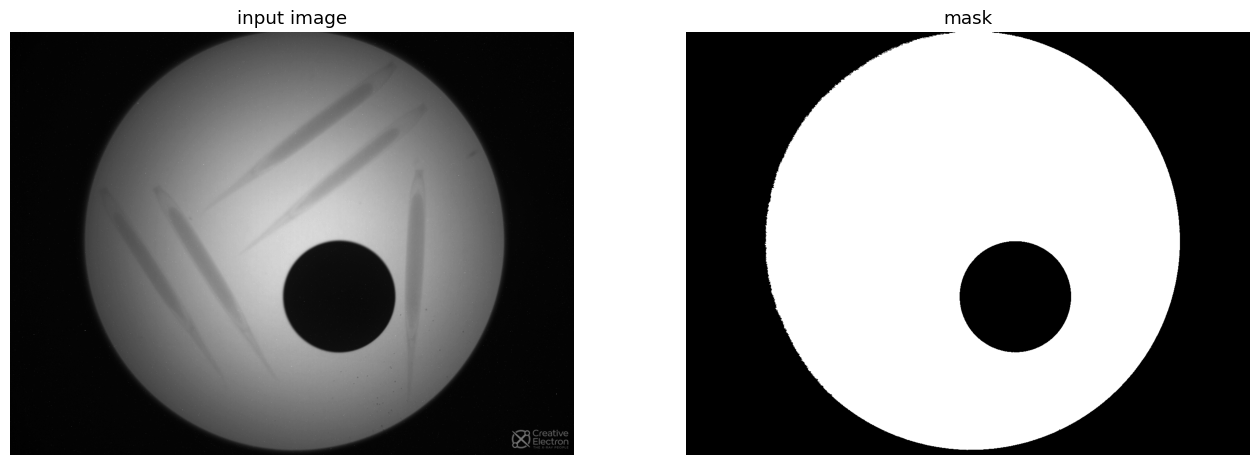

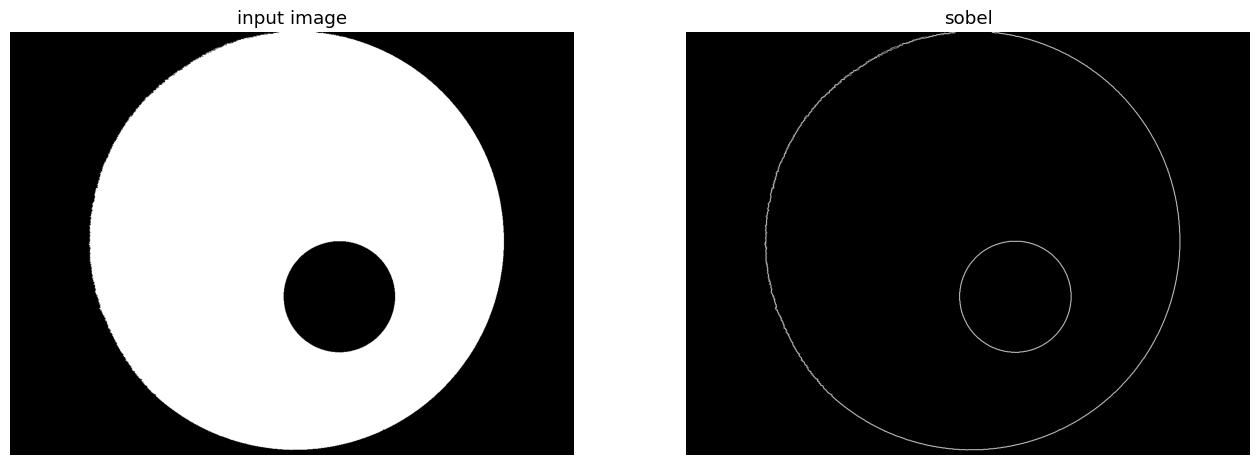

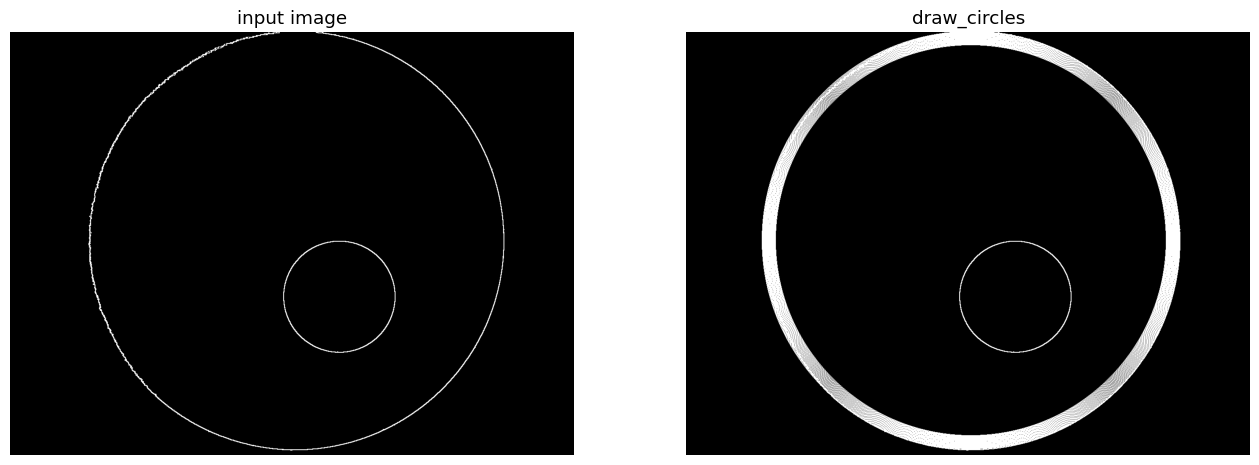

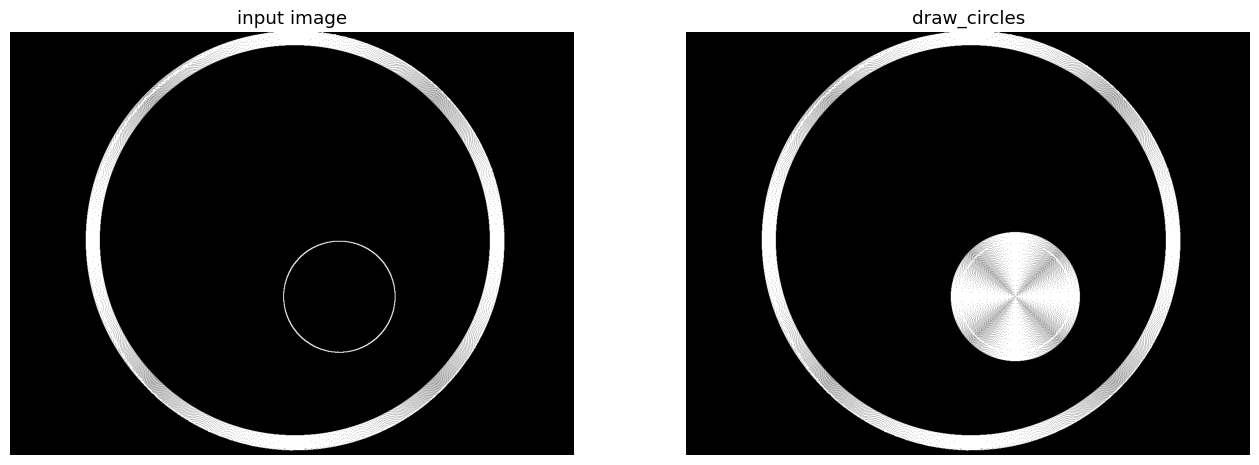

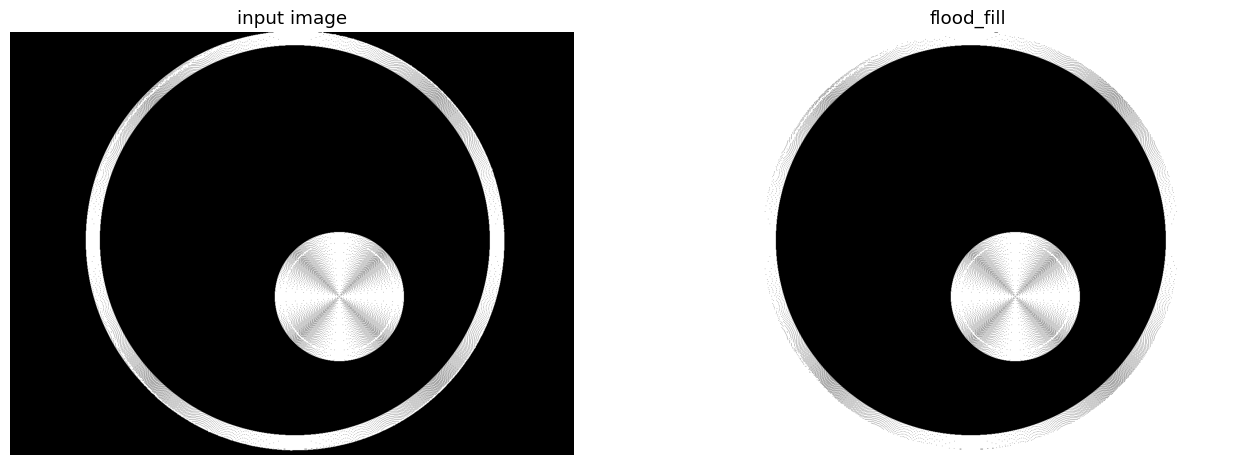

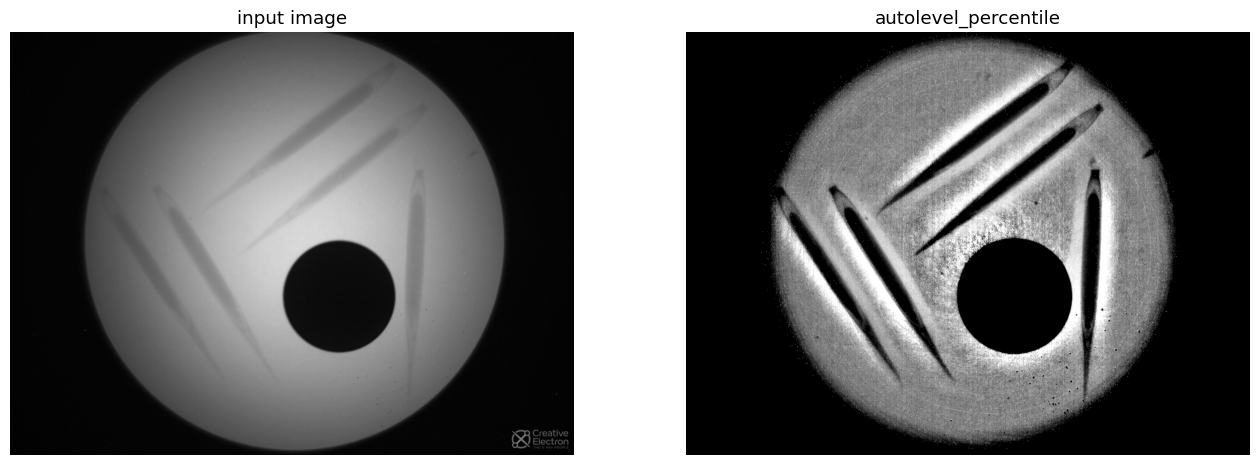

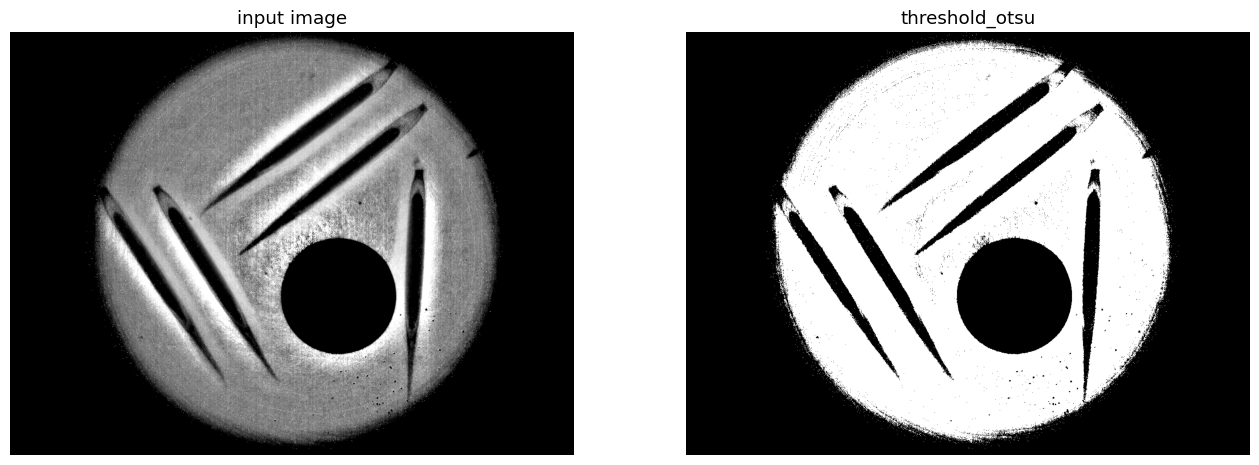

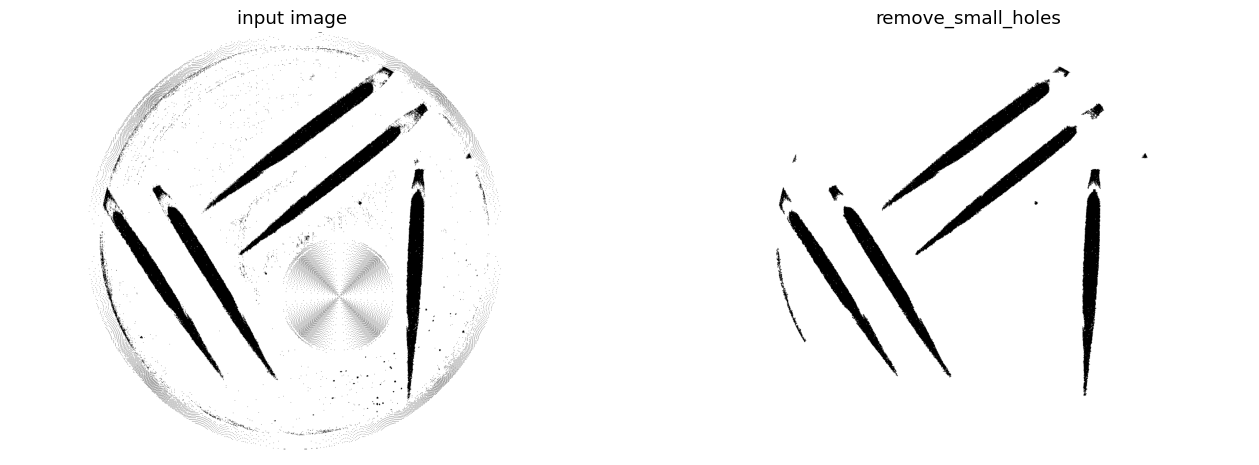

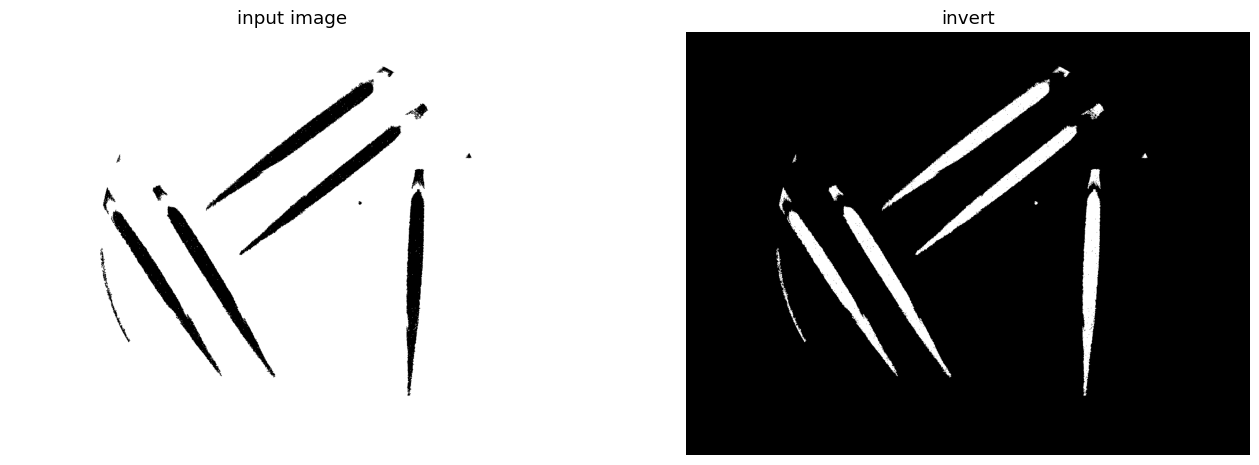

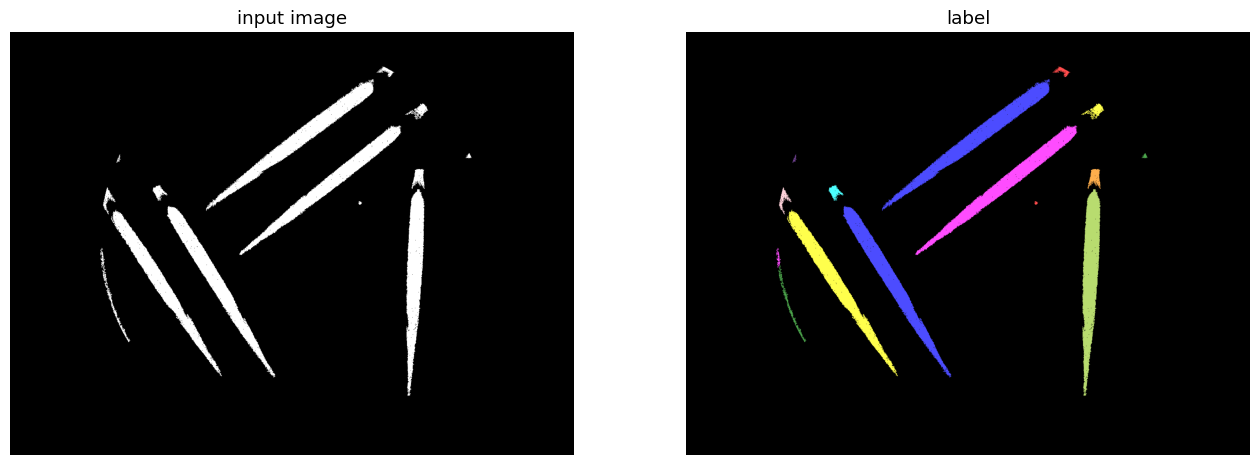

area 309.0
area_bbox 920.0
area_convex 528.0
area_filled 316.0
axis_major_length 37.76822410818706
axis_minor_length 17.198099618301136
bbox (79, 832, 102, 872)
centroid (88.75404530744336, 853.7152103559871)
centroid_local [ 9.75404531 21.71521036]
eccentricity 0.8903079291400703
equivalent_diameter_area 19.83509564693766
euler_number -6
extent 0.3358695652173913
feret_diameter_max 40.0
inertia_tensor [[ 81.92536735 -21.4121553 ]
 [-21.4121553   25.71296907]]
inertia_tensor_eigvals [89.15242201789015, 18.485914405063106]
label 1
moments [[3.09000000e+02 6.71000000e+03 1.71024000e+05 4.73716400e+06]
 [3.01400000e+03 7.20660000e+04 1.97938400e+06 5.76131280e+07]
 [3.73440000e+04 9.55932000e+05 2.72183700e+07 8.06691018e+08]
 [5.35010000e+05 1.43673900e+07 4.16204960e+08 1.23949245e+10]]
moments_central [[ 3.09000000e+02  1.42108547e-13  2.53149385e+04 -7.60965658e+04]
 [-7.10542736e-14  6.61635599e+03  2.38570312e+04  4.92599201e+05]
 [ 7.94530744e+03  1.59267123e+04  4.37513927e+05  1.

In [76]:
mask = get_mask(gray)

image = gray.copy()

edges = sobel(mask)
edges = edges > 0.2

circle1, circle2 = find_circles(edges, count=2)
edges = draw_circles(edges, circle1, circle1.radius - 32, circle1.radius)
edges = draw_circles(edges, circle2, 0, circle2.radius + 20)

edges = flood_fill(edges, (1, 1))

image = autolevel_percentile(image, mask=mask)

image = threshold_otsu(image)

image[edges] = 128  # (244, 29, 20)

# image = remove_small_objects(image, 64)
image = remove_small_holes(image, 32)

image = invert(image)

image = util.img_as_ubyte(image)
labels = label(image)

image_label_overlay = color.label2rgb(labels, image=image, bg_label=0)

for region in regionprops(labels):
    for prop in region:
        if prop not in "coords image image_convex image_filled".split():
            print(prop, region[prop])
    print()
# fig, ax = plt.subplots(figsize=(10, 6))
# ax.imshow(image_label_overlay)
# for region in regionprops(labels):
#     minr, minc, maxr, maxc = region.bbox
#     rect = mpatches.Rectangle(
#         (minc, minr),
#         maxc - minc,
#         maxr - minr,
#         fill=False,
#         edgecolor="blue",
#         linewidth=2,
#     )
#     ax.add_patch(rect)

# ax.set_axis_off()
# plt.tight_layout()
# plt.show()

print(image.dtype, image.shape)
print(mask.dtype, mask.shape)

## Use interactive graphics to explore image manipulations

I set it up so that you can use a partial pipeline, from above, and then run one of these interactive functions to see which arguments yield the best results.

In [55]:
# interact(
#     denoise_bilateral,
#     image=fixed(image),
#     # win_size=(0, 1000),
#     sigma_spatial=(0.0, 10.0),
# )

In [56]:
# interact(
#     subtract_mean_percentile_disk,
#     image=fixed(image),
#     mask=fixed(mask),
#     radius=(0, 1000),
#     p0=(0.0, 1.0),
#     p1=(0.0, 1.0),
# )

In [57]:
# interact(
#     threshold_sauvola,
#     image=fixed(image),
#     window_size=(1, 211, 2),
#     k=(0.0, 10.0),
# )

In [58]:
# interact(
#     denoise_nl_means,
#     image=fixed(image),
#     patch_size=(0, 1000),
#     patch_distance=(0, 1000),
#     h=(0.0, 10.0),
# )

In [59]:
# interact(
#     denoise_tv_chambolle,
#     image=fixed(image),
#     weight=(0.0, 10.0),
# )

In [60]:
# interact(
#     gaussian,
#     image=fixed(image),
#     sigma=(0.0, 10.0),
# )

In [61]:
# interact(
#     threshold_otsu,
#     image=fixed(image),
# )

In [62]:
# interact(
#     enhance_contrast_disk,
#     image=fixed(image),
#     mask=fixed(mask),
#     radius=(0, 1000),
# )

In [63]:
# interact(
#     sobel,
#     image=fixed(image),
#     mask=fixed(mask),
# )

In [64]:
# interact(
#     mean_bilateral_disk,
#     image=fixed(image),
#     mask=fixed(mask),
#     radius=(0, 1000),
# )

In [65]:
# new = image * 255.0
# new = util.img_as_int(image)
# interact(
#     noise_filter_disk,
#     image=fixed(new),
#     mask=fixed(mask),
#     radius=(1, 200),
# )

In [66]:
# interact(
#     canny,
#     image=fixed(image),
#     mask=fixed(mask),
#     sigma=(0.0, 10.0),
#     low_threshold=(0.0, 100.0),
#     high_threshold=(0.0, 100.0),
# )

In [67]:
# interact(
#     threshold_disk,
#     image=fixed(image),
#     mask=fixed(mask),
#     radius=(1, 200),
# )

In [68]:
# interact(
#     adjust_sigmoid,
#     image=fixed(image),
#     cutoff=(0.0, 1.0),
#     gain=(0.0, 100.0),
#     inv=False,
# )

In [69]:
# interact(
#     equalize_adapthist,
#     image=fixed(image),
#     kernel_size=(1, 2000),
#     clip_limit=(0.0, 1.0),
#     nbins=(1, 512),
# )

In [70]:
# interact(
#     adjust_gamma,
#     image=fixed(image),
#     gamma=(0.0, 10.0),
#     gain=(0.0, 10.0),
# )

In [71]:
# interact(
#     adjust_log,
#     image=fixed(image),
#     gain=(0.0, 100.0),
#     inv=False,
# )

In [72]:
# interact(
#     auto_level,
#     image=fixed(image),
#     footprint_disk=(0, 100),
#     low=(0.0, 1.0, 0.01),
#     high=(0.0, 1.0, 0.01),
# )

In [73]:
# interact(
#     unsharp_mask,
#     image=fixed(image),
#     radius=(0, 1000),
#     amount=(-20.0, 20.0),
# )

## Parked functions that may prove useful in the future

In [74]:
# def hough(binary, threshold=10, line_length=5, line_gap=4):
#     theta = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
#     lines = transform.probabilistic_hough_line(
#         binary,
#         threshold=threshold,
#         line_length=line_length,
#         line_gap=line_gap,
#         theta=theta,
#     )

#     # Generating figure 2
#     fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)
#     ax = axes.ravel()

#     ax[0].imshow(binary, cmap=plt.cm.gray)
#     ax[0].set_title("Binary Image")
#     ax[0].set_axis_off()

#     ax[1].imshow(binary, cmap=plt.cm.gray)
#     for line in lines:
#         p0, p1 = line
#         ax[1].plot((p0[0], p1[0]), (p0[1], p1[1]))
#     ax[1].set_xlim((0, binary.shape[1]))
#     ax[1].set_ylim((binary.shape[0], 0))
#     ax[1].set_title("Probabilistic Hough")
#     ax[1].set_axis_off()

#     plt.tight_layout()
#     plt.show()